In [1]:
import os
import csv
import sys
import json
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score

from collections import defaultdict

%matplotlib inline

In [2]:
sys.path.append('../src')
import plot_helpers as ph
pd.set_option('display.precision', 3)

In [3]:
experiment_id = "0"
experiment = json.load(open('../analysis.json'))["experiments"][experiment_id]

<ipython-input-4-a7d67d3f780f>:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 2, 2)
<ipython-input-4-a7d67d3f780f>:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 2, 2)


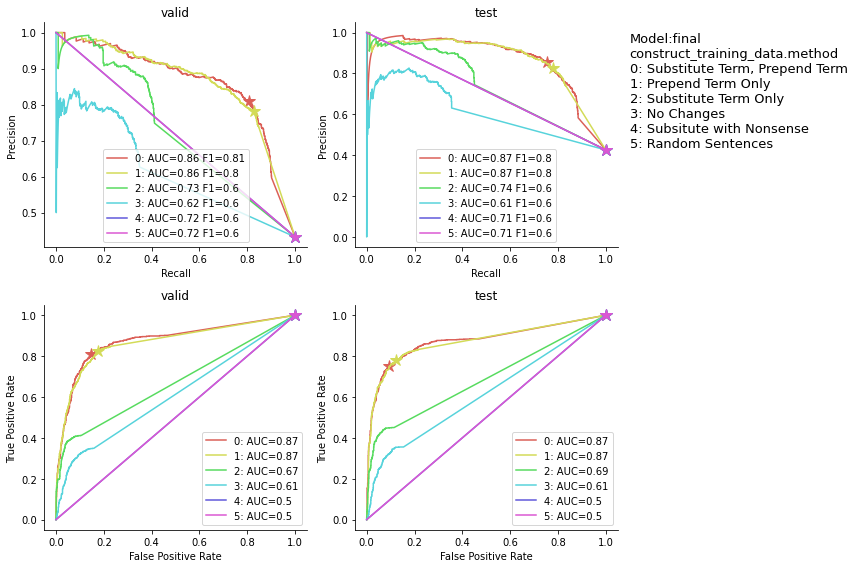

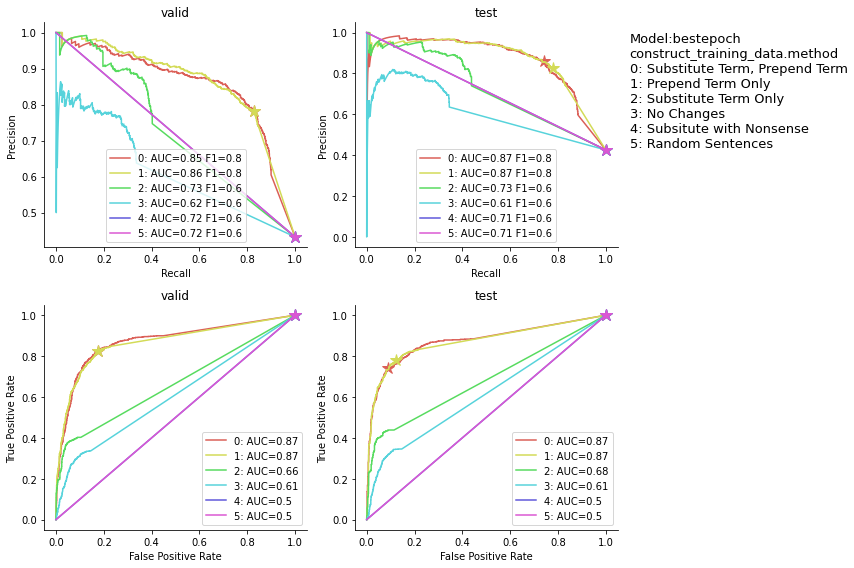

In [4]:
perfdata = defaultdict(lambda: defaultdict(list))

for modeltype in ('final', 'bestepoch'):
    resfiles = experiment[modeltype]
    colors = sns.color_palette("hls", len(resfiles))

    plt.figure(figsize=(12,8))
    plotcounter = 1


    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            perfdata[(modeltype, split)]['prdata'].append(prdata)
            
            plt.plot(prdata['recall'], prdata['precision'], color=colors[i], 
                     label=f'{i}: AUC={prdata["pr_auc"]:.2} F1={prdata["max_f1"]:.2}'
                    )
            plt.plot([prdata['max_f1_recall']], [prdata['max_f1_precision']], '*', color=colors[i], markersize=12)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        sns.despine()

    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            rocdata = ph.rocdata(split_df['label'], split_df['Pred1'], prdata['max_f1_threshold'])
            perfdata[(modeltype, split)]['rocdata'].append(rocdata)
            
            plt.plot(rocdata['fpr'], rocdata['tpr'], color=colors[i], 
                     label=f'{i}: AUC={rocdata["roc_auc"]:.2}'
                    )
            plt.plot([rocdata['max_f1_fpr']], [rocdata['max_f1_tpr']], '*', color=colors[i], markersize=12)

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        sns.despine()

    plt.subplot(2, 2, 2)
    reflegend = f'Model:{modeltype}\n{experiment["factor"]}\n' + '\n'.join([f"{i}: {s}" for i, s in enumerate(experiment['labels'])])
    plt.text(1.1, 1.0, reflegend, fontsize=13, verticalalignment='top')
    #plt.suptitle(modeltype)
    plt.tight_layout()
    
    plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}.pdf')

,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,"Substitute Term, Prepend Term",0.809,0.808,0.808,0.861,0.874,0.858,0.753,0.802,0.868,0.874
1,Prepend Term Only,0.783,0.826,0.804,0.861,0.866,0.827,0.780,0.803,0.869,0.870
2,Substitute Term Only,0.432,1.000,0.604,0.730,0.668,0.426,1.000,0.597,0.737,0.685
3,No Changes,0.432,1.000,0.604,0.616,0.608,0.426,1.000,0.597,0.612,0.613
4,Subsitute with Nonsense,0.432,1.000,0.604,0.716,0.500,0.426,1.000,0.597,0.713,0.500
5,Random Sentences,0.432,1.000,0.604,0.716,0.500,0.426,1.000,0.597,0.713,0.500


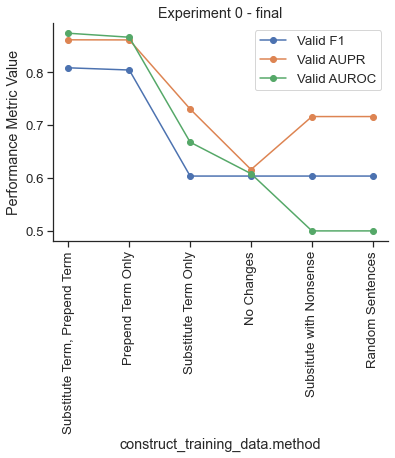

In [5]:
modeltype = 'final'
key = (modeltype, 'valid')
dfdata = {
    'Factor': experiment['labels'],
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(valid[col], 'o-', label=col)

plt.xticks(ticks = range(len(valid)), labels = valid['Factor'], rotation=90)
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment {experiment_id} - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

pd.concat([valid, test], axis=1)

# Replicate 1

In [8]:
experiment_id = "0R1"
experiment = json.load(open('../analysis.json'))["experiments"][experiment_id]

<ipython-input-9-a7d67d3f780f>:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 2, 2)
<ipython-input-9-a7d67d3f780f>:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 2, 2)


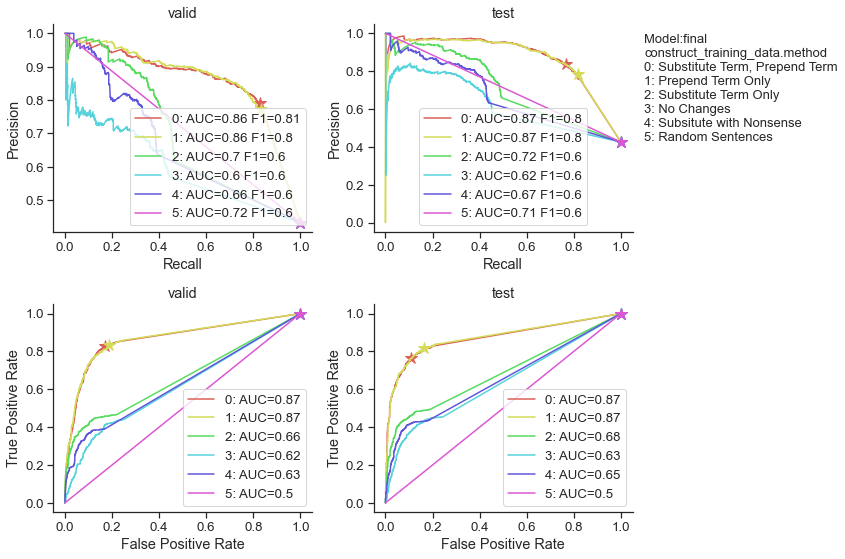

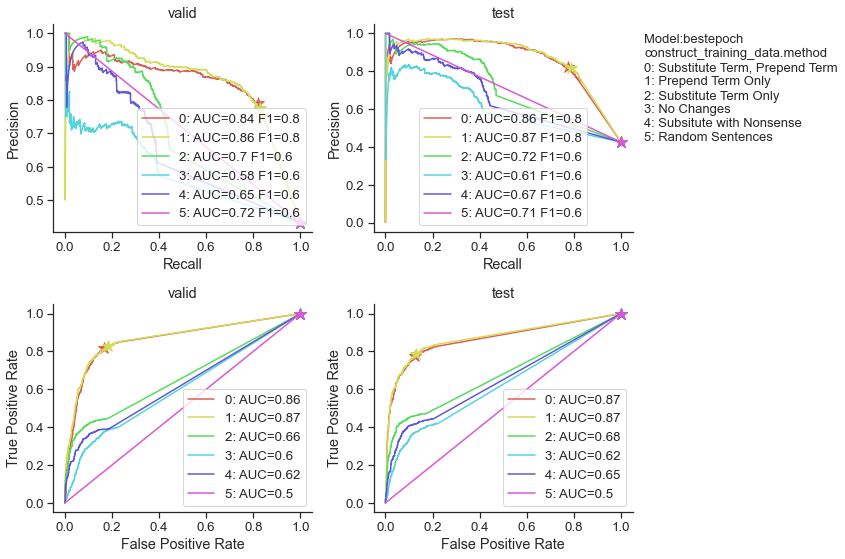

In [9]:
perfdata = defaultdict(lambda: defaultdict(list))

for modeltype in ('final', 'bestepoch'):
    resfiles = experiment[modeltype]
    colors = sns.color_palette("hls", len(resfiles))

    plt.figure(figsize=(12,8))
    plotcounter = 1


    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            perfdata[(modeltype, split)]['prdata'].append(prdata)
            
            plt.plot(prdata['recall'], prdata['precision'], color=colors[i], 
                     label=f'{i}: AUC={prdata["pr_auc"]:.2} F1={prdata["max_f1"]:.2}'
                    )
            plt.plot([prdata['max_f1_recall']], [prdata['max_f1_precision']], '*', color=colors[i], markersize=12)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        sns.despine()

    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            rocdata = ph.rocdata(split_df['label'], split_df['Pred1'], prdata['max_f1_threshold'])
            perfdata[(modeltype, split)]['rocdata'].append(rocdata)
            
            plt.plot(rocdata['fpr'], rocdata['tpr'], color=colors[i], 
                     label=f'{i}: AUC={rocdata["roc_auc"]:.2}'
                    )
            plt.plot([rocdata['max_f1_fpr']], [rocdata['max_f1_tpr']], '*', color=colors[i], markersize=12)

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        sns.despine()

    plt.subplot(2, 2, 2)
    reflegend = f'Model:{modeltype}\n{experiment["factor"]}\n' + '\n'.join([f"{i}: {s}" for i, s in enumerate(experiment['labels'])])
    plt.text(1.1, 1.0, reflegend, fontsize=13, verticalalignment='top')
    #plt.suptitle(modeltype)
    plt.tight_layout()
    
    plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}.pdf')

,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,"Substitute Term, Prepend Term",0.791,0.819,0.805,0.842,0.863,0.822,0.774,0.797,0.862,0.866
1,Prepend Term Only,0.776,0.830,0.802,0.857,0.868,0.819,0.788,0.803,0.869,0.872
2,Substitute Term Only,0.432,1.000,0.604,0.705,0.660,0.426,1.000,0.597,0.715,0.678
3,No Changes,0.432,1.000,0.604,0.585,0.603,0.426,1.000,0.597,0.611,0.621
4,Subsitute with Nonsense,0.432,1.000,0.604,0.653,0.624,0.426,1.000,0.597,0.666,0.647
5,Random Sentences,0.432,1.000,0.604,0.716,0.500,0.426,1.000,0.597,0.713,0.500


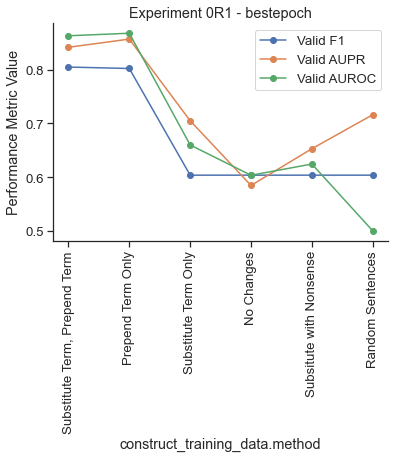

In [10]:
modeltype = 'bestepoch'
key = (modeltype, 'valid')
dfdata = {
    'Factor': experiment['labels'],
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(valid[col], 'o-', label=col)

plt.xticks(ticks = range(len(valid)), labels = valid['Factor'], rotation=90)
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment {experiment_id} - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

pd.concat([valid, test], axis=1)

,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,"Substitute Term, Prepend Term",0.790,0.828,0.809,0.856,0.867,0.841,0.767,0.802,0.874,0.870
1,Prepend Term Only,0.772,0.832,0.801,0.859,0.869,0.788,0.820,0.803,0.870,0.873
2,Substitute Term Only,0.432,1.000,0.604,0.698,0.659,0.426,1.000,0.597,0.715,0.684
3,No Changes,0.432,1.000,0.604,0.598,0.616,0.426,1.000,0.597,0.623,0.634
4,Subsitute with Nonsense,0.432,1.000,0.604,0.663,0.630,0.426,1.000,0.597,0.674,0.651
5,Random Sentences,0.432,1.000,0.604,0.716,0.500,0.426,1.000,0.597,0.713,0.500


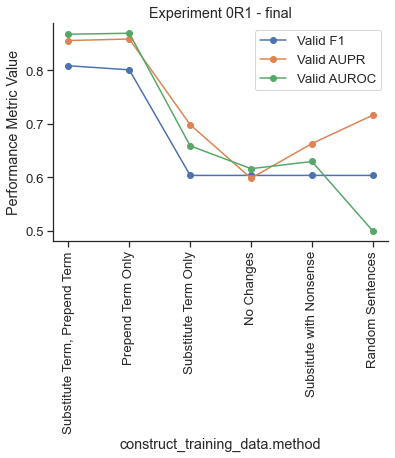

In [11]:
modeltype = 'final'
key = (modeltype, 'valid')
dfdata = {
    'Factor': experiment['labels'],
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(valid[col], 'o-', label=col)

plt.xticks(ticks = range(len(valid)), labels = valid['Factor'], rotation=90)
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment {experiment_id} - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

pd.concat([valid, test], axis=1)